In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
import sys
import seaborn as sns

from fastFM import als
from fastFM.datasets import make_user_item_regression
from scipy.sparse import csc_matrix, hstack, vstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

% matplotlib inline
sns.set_style('whitegrid')

### Import data

In [5]:
# import full data
data_path = os.path.join('..', 'data-2')
splits_path = os.path.join(data_path,'splits')
sparse_path = os.path.join(data_path, 'sparse')
columns = ['user','item','rating']

with open(os.path.join(splits_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)
    

# import sparse data    
sparse = dict()
features = ['actors', 'country', 'directors-imdb', 'genres-amazon', 'genres-imdb', 'language', 'mpaa',
           'studios-amazon', 'studios-imdb', 'type', 'user-item']
for feature in features:
    with open(os.path.join(sparse_path, feature + '.dict'), 'rb') as file_in:
        sparse[feature] = pkl.load(file_in)
        
# import results from LSH and Baseline
results_lsh_train = pd.read_csv(os.path.join(data_path, 'results_lsh_train.csv'))
results_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_lsh_cv.csv'))
results_lsh_test = pd.read_csv(os.path.join(data_path, 'results_lsh_test.csv'))

results_baseline_train = pd.read_csv(os.path.join(data_path, 'results_baseline_train.csv'))
results_baseline_cv = pd.read_csv(os.path.join(data_path, 'results_baseline_cv.csv'))
results_baseline_test = pd.read_csv(os.path.join(data_path, 'results_baseline_test.csv'))

# Train and test using output from LSH and Baseline

In [14]:
X_train = sparse['user-item']['train']
X_cv = sparse['user-item']['cv']
X_test = sparse['user-item']['test']

y_train = train_df['rating']
y_cv = cv_df['rating']
y_test = test_df['rating']

In [45]:
# define the objective function that the fmin module can later optimize on
def test_fm(params):
    print('==========TESTING FM==========')
    params['n_iter'] = int(params['n_iter'])
    params['rank'] = int(params['rank'])
    print(params)
    
    fm = als.FMRegression(**params)
    
    # add output from LSH and Baseline as feature for FM
    X_train_new = hstack([X_train,
                      results_baseline_train['pred'].values.reshape(X_train.shape[0],-1),
                      results_lsh_train['prediction'].values.reshape(X_train.shape[0],-1)])
    y_train = train_df['rating']
    
    X_cv_new = hstack([X_cv,
                      results_baseline_cv['pred'].values.reshape(X_cv.shape[0],-1),
                      results_lsh_cv['prediction'].values.reshape(X_cv.shape[0],-1)])
    y_cv = cv_df['rating'].values

    # build model and evaluate
    fm.fit(X_train_new, y_train)
    y_cv_pred = fm.predict(X_cv_new)
    mae = mean_absolute_error(y_cv_pred, y_cv)
    print('MAE:', mae)
    
    return mae

In [46]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_fm_lsh'), 'rb') as file_in:
        trials = pkl.load(file_in)
    with open(os.path.join(data_path, 'best_fm_lsh.dict'), 'rb') as file_in:
        best = pkl.load(file_in)
else:
    '''set the range of hyperparameters for the FM
    '''
    trials = Trials()
    space = {
        'n_iter': hp.uniform('n_iter', 100, 1000),
        'init_stdev': hp.uniform('init_stdev', 0, 1),
        'rank': hp.uniform('rank', 2, 5),
        'l2_reg_w': hp.uniform('l2_reg_w', 0, 11),
        'l2_reg_V': hp.uniform('l2_reg_V', 0, 11),
    }
    
    # Choose the Tree-structured Parzen Estimator (TPE) as the algorithm to optimize the objective function
    best = fmin(algo = tpe.suggest,
               fn = test_fm,
               trials = trials,
               max_evals = 100, # max number of tests
               space = space)
    with open(os.path.join(data_path, 'trials_fm_lsh'), 'wb') as file_out:
        pkl.dump(trials, file_out)
    with open(os.path.join(data_path, 'best_fm_lsh.dict'), 'wb') as file_out:
        pkl.dump(best, file_out)

==========TESTING FM==========
{'init_stdev': 0.9966751852890574, 'l2_reg_V': 9.89227139744409, 'l2_reg_w': 4.502123777756366, 'n_iter': 869, 'rank': 4}
MAE: 0.771513343288
==========TESTING FM==========
{'init_stdev': 0.639525086154633, 'l2_reg_V': 5.915611071459458, 'l2_reg_w': 0.7835771024703472, 'n_iter': 371, 'rank': 4}
MAE: 0.736049658752
==========TESTING FM==========
{'init_stdev': 0.26840465853836293, 'l2_reg_V': 10.832006329607708, 'l2_reg_w': 7.937454081273264, 'n_iter': 120, 'rank': 4}
MAE: 0.726197395396
==========TESTING FM==========
{'init_stdev': 0.45474018139944816, 'l2_reg_V': 0.8885456848414921, 'l2_reg_w': 1.7475591017688088, 'n_iter': 882, 'rank': 4}
MAE: 0.781339152482
==========TESTING FM==========
{'init_stdev': 0.3353788908806783, 'l2_reg_V': 2.2855159085283825, 'l2_reg_w': 7.30394092192552, 'n_iter': 614, 'rank': 2}
MAE: 0.722980530028
==========TESTING FM==========
{'init_stdev': 0.9908409836840452, 'l2_reg_V': 4.426847203025742, 'l2_reg_w': 5.228795815923634

MAE: 0.716460218876
==========TESTING FM==========
{'init_stdev': 0.0848228915521671, 'l2_reg_V': 6.9472015505755484, 'l2_reg_w': 0.6068949385232747, 'n_iter': 778, 'rank': 3}
MAE: 0.727848869028
==========TESTING FM==========
{'init_stdev': 0.5275817793103965, 'l2_reg_V': 8.58178528605128, 'l2_reg_w': 1.7964736994055936, 'n_iter': 378, 'rank': 2}
MAE: 0.717462316098
==========TESTING FM==========
{'init_stdev': 0.6171785340039735, 'l2_reg_V': 2.707568357258933, 'l2_reg_w': 7.118408995973256, 'n_iter': 969, 'rank': 4}
MAE: 0.748339601595
==========TESTING FM==========
{'init_stdev': 0.0009560885333220748, 'l2_reg_V': 0.30740716087817344, 'l2_reg_w': 3.891865210547571, 'n_iter': 461, 'rank': 2}
MAE: 0.76869769938
==========TESTING FM==========
{'init_stdev': 0.2575050569851881, 'l2_reg_V': 4.4826861445924635, 'l2_reg_w': 2.840665740014827, 'n_iter': 252, 'rank': 3}
MAE: 0.728121336197
==========TESTING FM==========
{'init_stdev': 0.3095438207119421, 'l2_reg_V': 1.5875763892910566, 'l2_r

MAE: 0.717009344949
==========TESTING FM==========
{'init_stdev': 0.5111487157585676, 'l2_reg_V': 5.748435214028644, 'l2_reg_w': 1.0897966767735077, 'n_iter': 782, 'rank': 3}
MAE: 0.722786532086
==========TESTING FM==========
{'init_stdev': 0.5434462217106134, 'l2_reg_V': 8.422877475787912, 'l2_reg_w': 4.888792622199707, 'n_iter': 812, 'rank': 2}
MAE: 0.716425332885
==========TESTING FM==========
{'init_stdev': 0.7092797809454129, 'l2_reg_V': 7.018314732862657, 'l2_reg_w': 7.466456002626748, 'n_iter': 637, 'rank': 3}
MAE: 0.742388843773
==========TESTING FM==========
{'init_stdev': 0.6533526753003236, 'l2_reg_V': 8.038287899619265, 'l2_reg_w': 2.2278381849349183, 'n_iter': 854, 'rank': 3}
MAE: 0.731567073311
==========TESTING FM==========
{'init_stdev': 0.38701699822449037, 'l2_reg_V': 9.65749380696346, 'l2_reg_w': 8.683167675171715, 'n_iter': 717, 'rank': 2}
MAE: 0.715745438208


In [55]:
def val_diagnostic(val_name, trials):
    '''generates scatter plot and histogram of each parameter, as well as a plot on loss values (MAE)'''
    
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    
    '''For hyperparameters that are specified with hp.choice, such as a range of integers,
       Hyperopt returns the index of the tested hyperparameter value rather than the value itself.
       Thus, for hyperparameter ranges that begin at a non-zero point,
       it is necessary to shift the indices to the corresponding values they represent.
    '''
    if val_name in ['n_iter', 'rank']:
        vals = [int(x) for x in vals]
        
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    plt.tight_layout()

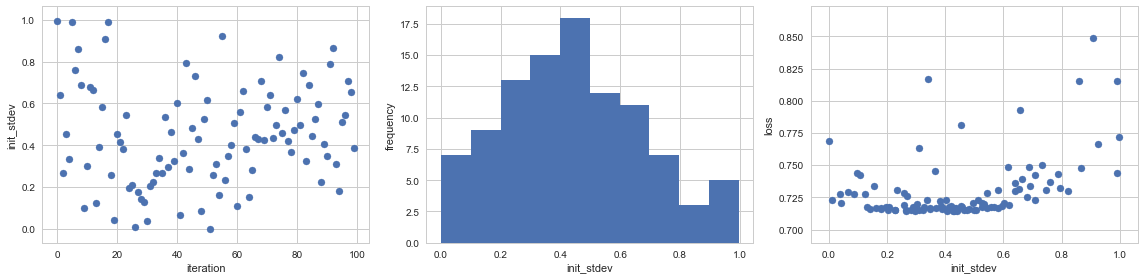

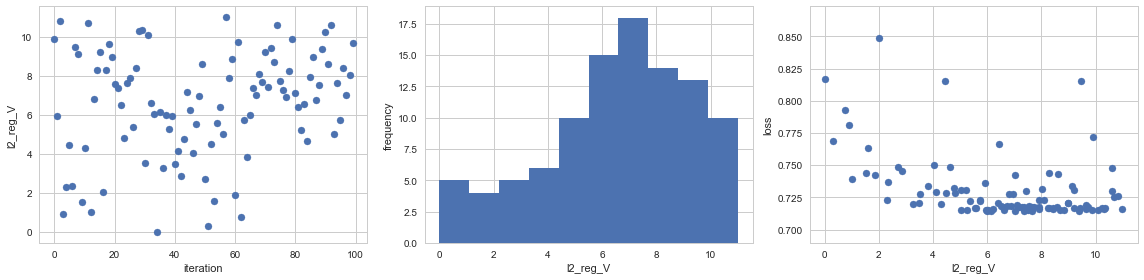

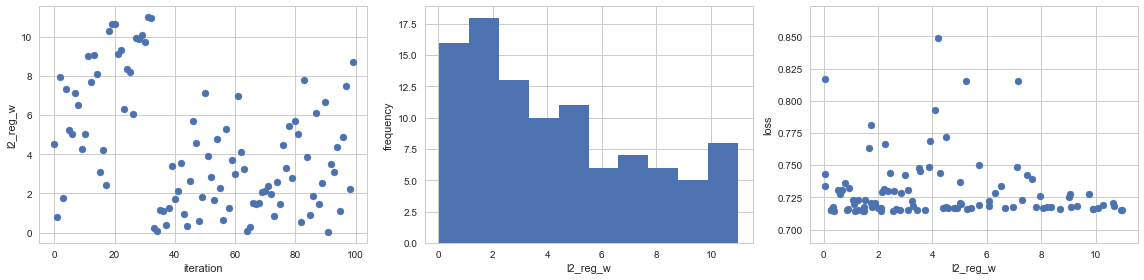

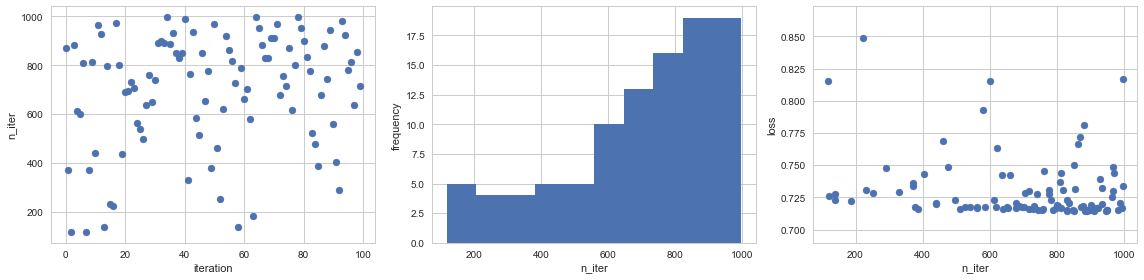

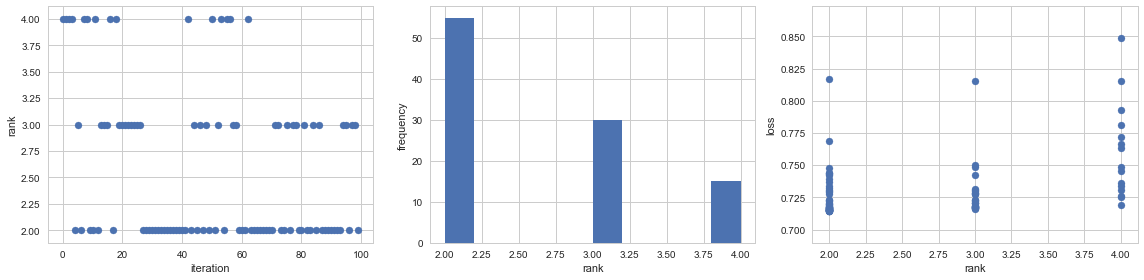

In [56]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [48]:
# optimized hyperparameter values
best_opt = best.copy()
best_opt['n_iter'] = int(best_opt['n_iter'])
best_opt['rank'] = int(best_opt['rank'])
best_opt

{'init_stdev': 0.44150440369618593,
 'l2_reg_V': 7.359513972428934,
 'l2_reg_w': 1.5012688971632053,
 'n_iter': 883,
 'rank': 2}

In [85]:
use_pretrained = True

if use_pretrained:
    train_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_train.csv'))
    cv_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_cv.csv'))
    test_results_df = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_test.csv'))
else:
    fm = als.FMRegression(**best_opt)
    fm.fit(X_train, y_train)
    
    y_train_pred = fm.predict(X_train)
    train_results_df = train_df[['user','item','rating']].copy()
    train_results_df['prediction'] = y_train_pred
    train_results_df.to_csv(os.path.join(data_path, 'results_fm_lsh_train.csv'), header=True, index=False)
    
    y_cv_pred = fm.predict(X_cv)
    cv_results_df = cv_df[['user','item','rating']].copy()
    cv_results_df['prediction'] = y_cv_pred
    cv_results_df.to_csv(os.path.join(data_path, 'results_fm_lsh_cv.csv'), header=True, index=False)
    
    y_test_pred = fm.predict(X_test)
    test_results_df = test_df[['user','item','rating']].copy()
    test_results_df['prediction'] = y_test_pred
    test_results_df.to_csv(os.path.join(data_path, 'results_fm_lsh_test.csv'), header=True, index=False)

mean absolute error, training set: 0.6456022004779508
mean absolute error, cross-validation set: 0.7197496268854381
mean absolute error, test set: 0.7129797740680126


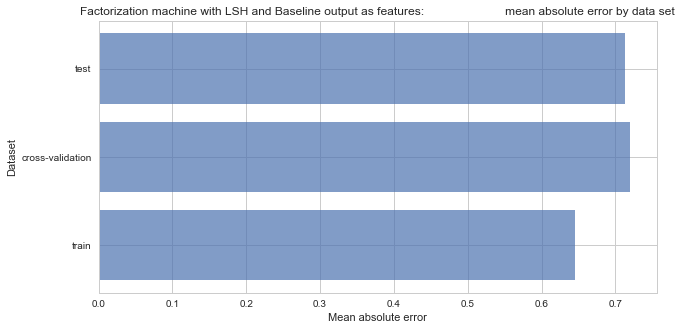

In [86]:
y_train_pred = np.clip(train_results_df['prediction'], a_min=1, a_max=5)
y_cv_pred = np.clip(cv_results_df['prediction'], a_min=1, a_max=5)
y_test_pred = np.clip(test_results_df['prediction'], a_min=1, a_max=5)

mae_train = np.abs(train_results_df['rating'] - y_train_pred).mean()
mae_cv = np.abs(cv_results_df['rating'] - y_cv_pred).mean()
mae_test = np.abs(test_results_df['rating'] - y_test_pred).mean()

print('mean absolute error, training set:', mae_train)
print('mean absolute error, cross-validation set:', mae_cv)
print('mean absolute error, test set:', mae_test)

mae_list = [mae_train, mae_cv, mae_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], mae_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'Factorization machine with LSH and Baseline output as features: \
                       mean absolute error by data set', ylabel = 'Dataset', xlabel = 'Mean absolute error')

ROC AUC, training set: 0.871109421574
ROC AUC, cross-validation set: 0.816937536571
ROC AUC, test set: 0.822597591651


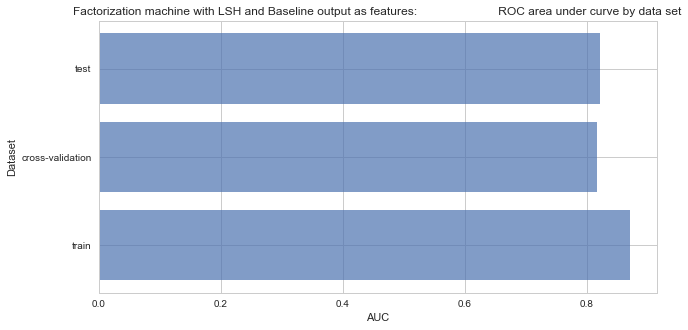

In [87]:
def calc_auc(data):
    y = data['rating'] >= 4
    y_pred = np.clip(data['prediction'], a_min=1, a_max=5)
    y_pred = y_pred / y_pred.max()
    auc = roc_auc_score(y, y_pred)
    return auc

auc_train = calc_auc(train_results_df)
auc_cv = calc_auc(cv_results_df)
auc_test = calc_auc(test_results_df)

print('ROC AUC, training set:', auc_train)
print('ROC AUC, cross-validation set:', auc_cv)
print('ROC AUC, test set:', auc_test)

auc_list = [auc_train, auc_cv, auc_test]

plt.figure(figsize = (10, 5))
ax = plt.barh([0,1,2], auc_list, alpha = 0.7)
plt.gca().set(yticks = [0,1,2], yticklabels = ['train', 'cross-validation', 'test'])
plt.gca().set(title = 'Factorization machine with LSH and Baseline output as features: \
                       ROC area under curve by data set', ylabel = 'Dataset', xlabel = 'AUC')

In [73]:
trials.trials[0]['misc']['vals'].keys()

dict_keys(['init_stdev', 'l2_reg_V', 'l2_reg_w', 'n_iter', 'rank'])